In [93]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Prepare for Dataset

In [9]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./sherlock.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 3381928
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [10]:
# Remove all non-printable characters
file = ''.join(list(filter((lambda x: x in all_chars), file)))

In [102]:
file_len = len(file)
print('Length of file: {}'.format(file_len))

Length of file: 3381831


In [12]:
# Get a random sequence of the Sherlock dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [103]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [53]:
class Net(nn.Module):
    def __init__(self, activation='RNN'):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        if activation == 'RNN':
            self.activation = nn.RNNCell(self.input_size, self.hidden_size)
        elif activation == 'LSTM':
            self.activation = nn.LSTMCell(self.input_size, self.hidden_size)
        
        self.act = activation
            
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state or (hidden, cell). It refers to the h_{t-1} or (h_{t-1}, c_(t-1)).
            Returns (output, hidden) or (output, hidden, cell) where output refers to y_t,
                     hidden refers to h_t and cell refers to c_t.
        """
        if self.act == 'RNN':
            hidden = self.activation(input, hidden)
            output = self.linear(hidden)
            return output, hidden
        else:
            hidden, cell = self.activation(input, hidden)
            output = self.linear(hidden)
            return output, hidden, cell

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
    def init_cell(self):
        # Initial cell state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    

#### Training Step and Evaluation Step

In [54]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    cell = net.init_cell()      # Initial cell state
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.
    
    if net.act == 'RNN':
        for t in range(seq_len):    # For each one in the input sequence.
            output, hidden = net(input[t], hidden)
            loss += loss_func(output, target[t])
    else:
        for t in range(seq_len):    # For each one in the input sequence.
            output, hidden, cell = net(input[t], (hidden, cell))
            loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [55]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    cell          = net.init_cell()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # If input net is RNN
    if net.act == 'RNN':
        # Use initial string to "build up" hidden state.
        for t in range(len(init_seq) - 1):
            output, hidden = net(init_input[t], hidden)
        # Set current input as the last character of the initial string.
        input = init_input[-1]
        
        # Predict more characters after the initial string.
        for t in range(predicted_len):
            # Get the current output and hidden state.
            output, hidden = net(input, hidden)
        
            # Sample from the output as a multinomial distribution.
            predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
            # Add predicted character to the sequence and use it as next input.
            predicted_char  = all_chars[predicted_index]
            predicted_seq  += predicted_char
        
            # Use the predicted character to generate the input of next round.
            input = seq_to_onehot(predicted_char)[0].to(device)
    
    # If input net is LSTM       
    else:
        # Use initial string to "build up" hidden state.
        for t in range(len(init_seq) - 1):
            output, hidden, cell = net(init_input[t], (hidden, cell))
        # Set current input as the last character of the initial string.
        input = init_input[-1]
        
        # Predict more characters after the initial string.
        for t in range(predicted_len):
            # Get the current output and hidden state.
            output, hidden, cell = net(input, (hidden, cell))
        
            # Sample from the output as a multinomial distribution.
            predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
            # Add predicted character to the sequence and use it as next input.
            predicted_char  = all_chars[predicted_index]
            predicted_seq  += predicted_char
        
            # Use the predicted character to generate the input of next round.
            input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Experiment

In [92]:
# Perform n_trials each for standard RNN and LSTM.

n_trials    = 3      # Number of trials per model
iters       = 20000  # Number of training iterations per trial.
print_iters = 100    # Number of iterations for each log printing.

Train standard RNN modesl:

In [59]:
# The loss variables.
all_losses_rnn = np.zeros(int(iters / print_iters))

# Training procedure.
for i in range(n_trials):
    net_rnn = Net()     # Create a new network instance.
    net_rnn.to(device)
    opt_rnn       = torch.optim.Adam(net_rnn.parameters(), lr=0.005)
    loss_func = nn.CrossEntropyLoss()
    losses = np.array([])
    loss_sum = 0
    for j in range(iters):
        input, target = get_input_and_target()            # Fetch input and target.
        input, target = input.to(device), target.to(device) # Move to GPU memory.
        loss      = train_step(net_rnn, opt_rnn, input, target)   # Calculate the loss.
        loss_sum += loss.item()                                  # Accumulate the loss.

        # Print the log.
        if j % print_iters == print_iters - 1:
            print('rnn_trial:{}, iter:{}/{} loss:{}'.format(i, j, iters, loss_sum / print_iters))
            print('generated sequence: {}\n'.format(eval_step(net_rnn)))
              
            # Track the loss.
            losses = np.append(losses, loss_sum / print_iters)
            loss_sum = 0
    all_losses_rnn += losses
    
mean_losses_rnn = all_losses_rnn / n_trials



rnn_trial:0, iter:99/20000 loss:3.0450429010391233
generated sequence: Wlflell,  aeae mti
Mahvk  ohopestooar "irrsnthe fruoiponat  essnmshoy  aomo ei tageoot   he s  s to m

rnn_trial:0, iter:199/20000 loss:2.743093583583832
generated sequence: W:auskispen st.  pnisao mind u. owso
 toneslo  sisn
 o  s on e. a srs d tvls e  id
o.
 on  o.
  e yer

rnn_trial:0, iter:299/20000 loss:2.455712985992432
generated sequence: W, surormiste bene hadattolun Hiwis khe tho  ho momral risesd iot aok to cre  wooldaf ty as men toand

rnn_trial:0, iter:399/20000 loss:2.3314148771762846
generated sequence: W

     saugomonveven the oreme
     I storted ungbon e siot, I
     fon to warn. "o
 f   Lisyouthinn

rnn_trial:0, iter:499/20000 loss:2.216069931983948
generated sequence: We te houmt d maad have doves Ptinemin lre'd shamec  hasd an rous I soked ap herwimishe
     ronder."

rnn_trial:0, iter:599/20000 loss:2.1562829077243806
generated sequence: We ce titte viovemldirjserd
     imend tues.

     "=Wend

KeyboardInterrupt: 

Train LSTM model:

In [62]:
all_losses_lstm = np.zeros(int(iters / print_iters))

for i in range(n_trials):
    net_lstm = Net('LSTM')    # Create a new network instance.
    net_lstm.to(device)
    opt_lstm      = torch.optim.Adam(net_lstm.parameters(), lr=0.005)
    loss_func = nn.CrossEntropyLoss()
    losses = np.array([])
    loss_sum = 0
    for j in range(iters):
        input, target = get_input_and_target()            # Fetch input and target.
        input, target = input.to(device), target.to(device) # Move to GPU memory.
        loss      = train_step(net_lstm, opt_lstm, input, target)   # Calculate the loss.
        loss_sum += loss.item()                                  # Accumulate the loss.

        # Print the log.
        if j % print_iters == print_iters - 1:
            print('lstm_trial:{}, iter:{}/{} loss:{}'.format(i, j, iters, loss_sum / print_iters))
            print('generated sequence: {}\n'.format(eval_step(net_lstm)))
              
            # Track the loss.
            losses = np.append(losses, loss_sum / print_iters)
            loss_sum = 0
    all_losses_lstm += losses

mean_losses_lstm = all_losses_lstm / n_trials

lstm_trial:0, iter:99/20000 loss:3.080527868270874
generated sequence: W@8n aeonolthety pea    e  Bvw.a  ead
e ScWmt ,ttrnae  a.arn  sovoon Ih vopsn sona  ist "vaweeaakp y 

lstm_trial:0, iter:199/20000 loss:2.7117110085487366
generated sequence: W-a d con  c erlattidthaid ht btny ild mencont qacytay "ur ure alr uosy in then, hend byve, 
     anl

lstm_trial:0, iter:299/20000 loss:2.3301154136657716
generated sequence: Wononas e
     I Hsofissd chot she

     Uy
     Htat-nalg ursades d uh co padg winnd. bupnet ecby ep

lstm_trial:0, iter:399/20000 loss:2.243862261772156
generated sequence: Whk thet I Gicas. aj thiul aveas a mebt"olt il at mas ald rait wimade cyoch thinlef if intithay ald w

lstm_trial:0, iter:499/20000 loss:2.181271368265152
generated sequence: Whe sever
     ath mno wer soudd wive mo Hous ow umemon e tonkim to thert kea, consert, sond."

     

lstm_trial:0, iter:599/20000 loss:2.105839502811432
generated sequence: Woe id onof I Yar wouldingr, ti Ik.

     I Onal me 

#### Training Loss Curve

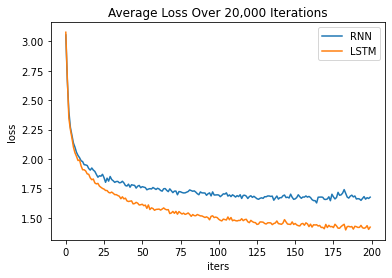

In [64]:
plt.title("Average Loss Over 20,000 Iterations")
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(mean_losses_rnn)
plt.plot(mean_losses_lstm)
plt.legend(['RNN', 'LSTM'])
plt.show()

#### Evaluation: A Sample of Generated Sequence for Each Model

Text generated by standard RNN model:

In [101]:
print(eval_step(net_rnn, predicted_len=600))

What---emolitial cocketing, suite the chara-erd hat beewly clayipay we, with. The stason tist would of, who ever-thalk rurgly, ky don't was the kide, the
     us who up all our we, now. Acces, so durto ot,     sciped than I eregg was upon the mikh who indimemely mack to answery so werte. As the fury has
     well orr contost. The, but the
     where-has right after twat what had only compawionco for it, his, fow."

     "I was is might to a farish conther for no, Mr. Holvelanills miscacNes, into to have tron comsirian mas was whoshionly scation," said the ratproturn to paperfold face. The nittl


Text generated by LSTM model:

In [95]:
print(eval_step(net_lstm, predicted_len=600))

Wake his brother's hous grands
     it nor givneves me, but nexs. -yec the dear's.  "And
     before's paper. It saw I were asceether
     twecher as
     and the tuin's in Toth of been bach of somethin of his own tatten
     deacles me to me, trees upon the sappo.

     ""Good jom so fack
     was done, is contarge all vading which was as the
     case flayhed in Naskless court.'

     'It was aloce to detentsing-    interest. If with welled semponded to my part, tound to the put to say to
     became of paper made up gurtless in eyes arm our lequer a mission, I sended some family.

     "I sa
